# Draw

## Boilerplate

In [16]:
import numpy  as np
from copy import copy

import random
import math
import itertools

from random import random, shuffle, uniform, randint
from io import BytesIO

import cairo
import IPython.display
import PIL
import PIL.Image

In [17]:
XMAX = 105
XMIN = -XMAX
YMAX = 195
YMIN = -90

XMID = (XMAX + XMIN) / 2.0
YMID = (YMAX + YMIN) / 2.0

PEN_DELAY = 125

START_X = 0
START_Y = -200

In [18]:
def clamp(value, min_value, max_value):
    return min(max(value, min_value), max_value)

In [19]:
class GCODE:
    def __init__(self, name="foobar", feedrate=1000):
        self.start_pos = np.array([START_X, START_Y])
        self.pos = copy(self.start_pos)
        self.f = open(f"{name}.gcode", "wt")
        self.feedrate = feedrate
        
        self.servo = "P0"
        self.pen_up_pos = "S0"
        self.pen_down_pos = "S90"
         
        self.f.write("M17\n")  # Ensure steppers are enabled
        self.f.write("M121\n")  # Disable endstops, just in case
        self.f.write("G90\n")  # Set absolute positioning
        self.f.write("; potatolangelo\n")
        self.pen_up()
        self.move_to_starting_position()
        
    def pen_up(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_up_pos} T{PEN_DELAY}\n")
    
    def pen_down(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_down_pos} T{PEN_DELAY}\n")
        
    def finish_moves(self):
        self.f.write("M400\n")
        
    def move_to(self, x, y, feedrate=None):
        feedrate = feedrate or self.feedrate
        
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def move_to_mid_point(self, feedrate=None):
        self.move_to(XMID, YMID, feedrate=feedrate)
        
    def move_to_starting_position(self, feedrate=None):
        self.move_to(self.start_pos[0], self.start_pos[1], feedrate=feedrate)
        
    def step(self, dx, dy, feedrate=None):
        feedrate = feedrate or self.feedrate
        self.pos[0] += dx
        self.pos[1] += dy
        
        x = self.pos[0]
        y = self.pos[1]
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def square_filled(self, xmin, ymin, xmax, ymax, dy=1, zigzag=True):
        print(f"square filled centered on {(xmin + xmax) / 2.0:.2f} {(ymin + ymax) / 2.0:.2f}")
        
        self.pen_up()    
        self.move_to((xmin + xmax) / 2.0, (ymin + ymax) / 2.0)
        
        self.square(xmin, ymin, xmax, ymax)
        
        self.pen_up()    
        self.move_to(xmin, ymin)
        self.pen_down()
        
        x = xmin
        y = ymin
        while y < ymax:
            y += dy
            
            # When zigzag is true the pen moves in a saw tooth pattern,
            # otherwise it goes in a square wave form.
            # Zigzag looks good with ballpoint pens, while the square pattern
            # works best on thicker points.
            if not zigzag:
                self.move_to(x, y)
            
            if x == xmin:
                x = xmax
            else:
                x = xmin
                
            self.move_to(x, y)
            
        self.pen_up()
                
    def square(self, xmin, ymin, xmax, ymax):
        self.move_to(xmin, ymin)
        self.pen_down()
        self.move_to(xmax, ymin)
        self.move_to(xmax, ymax)
        self.move_to(xmin, ymax)
        self.move_to(xmin, ymin)
        self.pen_up()
            
    def flush(self):
        self.f.flush()

# The actual algo

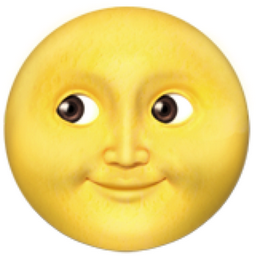

In [20]:
image_name = "full-moon-with-face.png"

IPython.display.Image(filename=image_name) 

In [24]:
original_image = PIL.Image.open(image_name)
image_pixels = original_image.convert('RGB')

In [58]:
points = []

width = original_image.width
height = original_image.height

for y in range(height):
    for x in range(width):
        r, g, b = image_pixels.getpixel((x, y))
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
        
        if random() < intensity * 0.05:
            points.append(np.array((x, y)))
            
len(points)

785

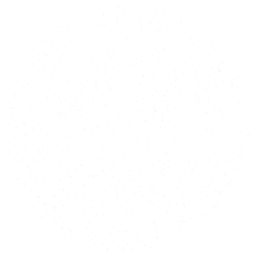

In [59]:
svgio = BytesIO()

with cairo.SVGSurface(svgio, width, height) as surface:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.001)
    context.set_source_rgba(0, 0, 0, 1)
    context.set_line_cap(cairo.LINE_CAP_ROUND)
    
    for x, y in points:
        context.move_to(x / width, y / height)
        context.line_to(x / width, y / height)
        context.stroke()

IPython.display.SVG(data=svgio.getvalue())

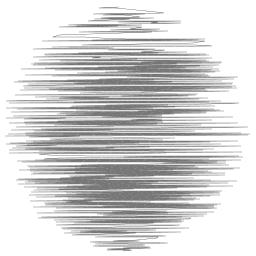

In [60]:
svgio = BytesIO()

with cairo.SVGSurface(svgio, width, height) as surface:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.001)
    context.set_source_rgba(0, 0, 0, 1)
    context.set_line_cap(cairo.LINE_CAP_ROUND)
    context.move_to(points[0][0] / width, points[0][1] / height)
    
    for x, y in points:
        context.line_to(x / width, y / height)
    
    context.stroke()

IPython.display.SVG(data=svgio.getvalue())

In [61]:
def path_length(path):
    return sum([
            np.linalg.norm(a - b) for a, b in itertools.pairwise(path)
    ])

In [62]:
path_length(points)

48125.677833526635

Generate the Gcode

In [63]:
shuffle(points)
path_length(points)

89179.81507984964

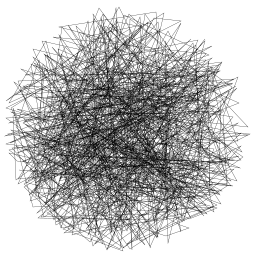

In [64]:
svgio = BytesIO()

with cairo.SVGSurface(svgio, width, height) as surface:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.001)
    context.set_source_rgba(0, 0, 0, 1)
    context.set_line_cap(cairo.LINE_CAP_ROUND)
    context.move_to(points[0][0] / width, points[0][1] / height)
    
    for x, y in points:
        context.line_to(x / width, y / height)
    
    context.stroke()

IPython.display.SVG(data=svgio.getvalue())

Optimize the path

In [74]:
def two_swap(state, swap_position=None):
    if swap_position:
        x, y = swap_position
    else:
        x = randint(0, len(state) - 1)
        y = randint(0, len(state) - 1)
    
    t = state[x]
    state[x] = state[y]
    state[y] = t
    
    return state, (x, y)


def cost(state):
    return path_length(state)


def optimize(initial_solution):
    current_state = initial_solution
    current_cost = cost(current_state)
    starting_cost = current_cost
    temperature = 100
    
    iterations = 0
    
    while temperature > 0.01:
        iterations += 1
        
        if iterations % 100 == 0:
            print(f"{temperature:7.2f} {starting_cost - current_cost:9.2f}")
        
        new_state, swap_position = two_swap(current_state)
        new_cost = cost(new_state)
        delta_e = current_cost - new_cost

        if delta_e > 0.0:
            # current_state = new_state
            current_cost = new_cost
        elif uniform(0, 1) < math.exp(-delta_e / temperature):
            # current_state = new_state
            current_cost = new_cost
        else:
            two_swap(current_state, swap_position)
                
        temperature -= 0.01
        
    return current_state

In [75]:
print(f"starting length: {path_length(points):.2f}")
optimize(points)
print(f"optimized length: {path_length(points):.2f}")

starting length: 89075.51
  99.01   1214.48
  98.01   2709.56
  97.01   3692.09
  96.01   2406.32
  95.01   1491.02
  94.01    936.87
  93.01   1458.28
  92.01    822.41
  91.01    803.24
  90.01   1604.51
  89.01   1126.28
  88.01   1942.93
  87.01   2259.71
  86.01   3472.52
  85.01   1963.46
  84.01   1189.81
  83.01   1585.79
  82.01   1619.01
  81.01   2050.20
  80.01   2145.04
  79.01   2475.52
  78.01   1986.31
  77.01   3800.21
  76.01   2981.88
  75.01   2830.27
  74.01   2734.80
  73.01   3480.86
  72.01   3561.67
  71.01    562.96
  70.01    803.60
  69.01    156.07
  68.01    309.36
  67.01    481.46
  66.01   1750.98
  65.01   1826.94
  64.01    273.61
  63.01   1846.19
  62.01   2886.48
  61.01   3111.01
  60.01   2711.85
  59.01   2510.79
  58.01   5091.14
  57.01   5797.67
  56.01   5421.36
  55.01   1679.08
  54.01    702.85
  53.01   1463.84
  52.01   1316.40
  51.01    973.82
  50.01   1302.80
  49.01   1934.97
  48.01   1091.63
  47.01   1647.05
  46.01   3313.04
  

OverflowError: math range error

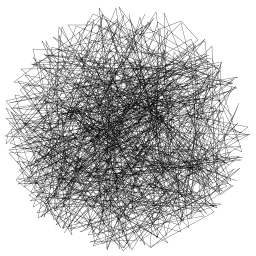

In [73]:
svgio = BytesIO()

with cairo.SVGSurface(svgio, width, height) as surface:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.001)
    context.set_source_rgba(0, 0, 0, 1)
    context.set_line_cap(cairo.LINE_CAP_ROUND)
    context.move_to(points[0][0] / width, points[0][1] / height)
    
    for x, y in points:
        context.line_to(x / width, y / height)
    
    context.stroke()

IPython.display.SVG(data=svgio.getvalue())

In [53]:
filename = "test"

gcode = GCODE(filename, feedrate=1000)



gcode.move_to_starting_position()
gcode.flush()

# Preview

In [ ]:
svgio = BytesIO()
filename = f"{filename}.gcode"

last_x = (START_X - XMIN) / (XMAX - XMIN)
last_y = (START_Y - YMIN) / (YMAX - YMIN)

width = 210
height = 297

drawing = False

with cairo.SVGSurface(svgio, width, height) as surface, open(filename) as f:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.0025)
    context.set_source_rgba(0, 0, 0, 1)
    
    for line in f.readlines():
        if "G0" in line:
                
            tokens = line.strip().split(" ")[1:]
            x = (float(tokens[0][1:]) - XMIN) / (XMAX - XMIN)
            y = (float(tokens[1][1:]) - YMIN) / (YMAX - YMIN)

            if writing:  
                context.move_to(last_x, last_y)
                context.line_to(x, y)
                context.stroke()

            last_x = x
            last_y = y
            
        if "M280 P0" in line:
            tokens = line.strip().split(" ")[1:]
            if tokens[1] == "S0":
                writing = False
            elif tokens[1] == "S90":
                writing = True

IPython.display.SVG(data=svgio.getvalue())